### First we execute the required libraries ####

In [2]:
%reset -f 

import numpy as np
import math
from datetime import datetime
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy import stats
import scipy.optimize as optimization
from scipy.optimize import minimize
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statistics import mean
import numpy as npa
import seaborn as sns
import os
from Bio import SeqIO
import numpy as np
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
from scipy import stats
import random
from sklearn import linear_model
from scipy.special import expit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from IPython.display import clear_output
from operator import itemgetter
from math import comb
from scipy.stats import norm
import itertools
import warnings
warnings.filterwarnings('ignore')

import ast
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as plotly


plotly.io.orca.config.executable = '/home/indio/anaconda3/envs/openmm/bin/orca'
plotly.io.orca.config.save()


def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

# pd.set_option("display.max_rows", None)

### Second, execute all the modules ###

In [3]:
#version chatgtp
def matriz(file):
    fasta = list(SeqIO.parse(file, "fasta"))
    secuencias = np.array([x.seq for x in fasta])
    ogts = np.array([np.log10(np.float16(z.id.split('_')[-1])) for z in fasta])
#     ogts = np.array([np.log10((np.float16(z.id.split('_')[-1]))) for z in fasta])

#     print('A0')
    ogtscomp = np.abs(ogts[:, None] - ogts)
#     print('A1')
    b = (secuencias[:, None] != secuencias).reshape(-1, secuencias.shape[-1]).astype(np.uint8)
    npos = np.shape(b)[1]
    suma = (np.sum(b, axis=1, dtype=np.float32)/npos)*100
#     print('A2')
    x, y = np.meshgrid(np.arange(len(secuencias)), np.arange(len(secuencias)), indexing='ij')
#     print('A3')
    df = pd.concat([pd.DataFrame(b), pd.DataFrame(np.stack((suma, ogts[x.ravel()], ogts[y.ravel()], ogtscomp.ravel(), x.ravel(), y.ravel())).T, columns=['sum', 'TA', 'TB', 'dif', 'X', 'Y'])], axis=1)
#     print('A4')
    del fasta, ogts, ogtscomp, b, suma, x, y
    return df, npos, secuencias

# Dataframe de entrenamiento. Solo comparo y filtro las secuencias del set de entrenamiento
# EL MEJOR RESULTADO DA CALIBRANDO CON DELTAFEATURE >= 1

def rindividual(limsup, liminf, colseqA, colseqB, cutofffeature, df):
    listaR=[]
    df = df[(df['sum'] <= limsup) & (df['sum'] >= liminf) & (df['dif'] >= cutofffeature)]
    listaR = np.empty(npos, dtype=object)
#     print('B1')
    for i in range(0,npos):
        r = stats.spearmanr(np.asarray(df[i]),np.asarray(df['dif']))
        var = i,r.statistic
        listaR[i] = var
    return listaR, df

import numpy as np
from operator import itemgetter

def ordering():
    ordered = []
    for x, y in enumerate(listaR):
        if y[1] >= 0 or y[1] < 0:
            z = (x, y[1])
            ordered.append(z)
        else:
            z = (x, 0)
            ordered.append(z)

    indexes = sorted(ordered, key=lambda k: [k[1], k[0]], reverse=True)
    indices = [j[0] for i, j in enumerate(indexes)]
    rs = [j[1] for i, j in enumerate(indexes)]

    sum_so_far = np.zeros(df4.shape[0])
    r2 = []
    posicion = []

    for i in range(1, npos + 1):
        suma = sum_so_far + df4[indices[i - 1]]
        sum_so_far = suma
        r = stats.spearmanr(df4['dif'], suma)
        r = r.statistic
        r2.append(r)
        posicion.append(i - 1)

    grouppos = max((list(zip(posicion, r2))), key=itemgetter(1))[0]
    print(f"{grouppos + 1} number of positions maximize the correlation")

    indices2 = indices[0: int(grouppos) + 1]
    indices3 = [x + 1 for x in indices2]
    print(indices3)

    return ordered, indexes, indices, indices2, posicion, r2, rs

def selectres(subsetres):
    suma = np.sum(df4[subsetres], axis=1)
    r, _ = stats.spearmanr(suma, df4['dif'])

    return suma

def calibracion2(degree,sumacal):
    linear, intercept = np.polyfit(sumacal, df4['dif'],degree)
    r2score = linregress(sumacal, df4['dif'])[2]
    return linear, intercept, r2score

def trainval(trcut, colseqA, colseqB, indices2):
    cutrain = trcut
    nrodesecuencias = len(secuencias)
    nroseqtrain = int(nrodesecuencias * cutrain)
    
    df2 = df.loc[:, df.columns.isin(indices2 + ['sum', 'X', 'Y', 'dif', 'TA', 'TB'])]
    listrain = np.random.choice(nrodesecuencias, nroseqtrain, replace=False)
    train = df2[(df2[colseqA].isin(listrain)) & (df2[colseqB].isin(listrain))]
    val = df2[(~df2[colseqA].isin(listrain)) & (df2[colseqB].isin(listrain))]

    return listrain, train, val

from scipy.optimize import minimize

def squared_difference(t, deltaOGTp, dfalt):#, lambda_):
    return sum((deltaOGTp - np.abs(dfalt['TB'] - t)) ** 2)
def minimization_routine(t_initial, deltaOGTp, dfalt):#, lambda_):
    options = {'gtol': 1e-22, 'tol': 1e-20}
    res = minimize(squared_difference, t_initial, args=(deltaOGTp, dfalt), method='L-BFGS-B', options = options)
#     res = minimize(squared_difference, t_initial, args=(deltaOGTp, dfalt, lambda_), method='L-BFGS-B', tol = 1e-8)
    options = {'maxiter': 10000}
    t_opt = res.x[0]
    rms_opt = res.fun
    return t_opt, rms_opt


def entrenamiento(valsup, valinf, colseqA, colseqB, secuencia, ti, tf, step, n, m, b):
    result = []
    df4tt = val[(val['sum'] <= valsup) & (val['sum'] >= valinf)]
    dfalt = pd.DataFrame()
    for i in secuencia,:
        dfalt = df4tt.loc[df4tt['X'] == i]
        listaAlt = pd.DataFrame({'ploterciario': dfalt[indices2].sum(axis=1)})
        dfalt = listaAlt.join(dfalt[['TA', 'TB', 'X']])
        dfalt = dfalt[dfalt['ploterciario'] <= 900]
        if dfalt.empty:
            resumen = (i, 'vacio')
            break
        else:
            deltaOGTp = quad * dfalt['ploterciario'] * dfalt['ploterciario'] + linear * dfalt['ploterciario'] + intercept
            Treal = dfalt['TA'].loc[dfalt['X'] == i].unique()[0]
            t_initial = [1000]
            t_opt, rms_opt = minimization_routine(t_initial, deltaOGTp, dfalt)
            resumen = (i, colseqB, t_opt, rms_opt, Treal)
            result.append(resumen)
    return resumen, dfalt, listaAlt

def prediccion(superior, inferior, colseqA, colseqB, parami, paramf, quadratic, linear, intercept):
    results4 = []
    results2 = []
    diferencia = []
    for i in val[colseqA].unique():
        result, dfalt, listaAlt = entrenamiento(superior, inferior, colseqA, colseqB, i, parami, paramf, stepp, quadratic, linear, intercept)
        if result[1] != 'vacio':
            results4.append(result[4])
            results2.append(result[2])
            diferencia.append(result[4] - result[2])
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(results4, results2)
    return slope2, intercept2, r_value2, p_value2, std_err2, results2, results4, diferencia, result

def selectres_train(subsetres, train):
    suma = np.sum(train[subsetres], axis=1)
    r, _ = stats.spearmanr(suma, train['dif'])

    return suma

def calibracion2_train(degree, train, suma):
    linear, intercept = np.polyfit(suma, train['dif'],degree)
    r2score = linregress(suma, train['dif'])[2]
    return linear, intercept, r2score

### Third, find positions ###

In [4]:
# %%timeit
# print(datetime.now())
secsup=1000
secinf=0
colseqA='X'
colseqB='Y'
cutofffeature=0

file='ccmb.fas'

listaR=[]

fasta = SeqIO.parse(file, "fasta")
secuencias = [ x.seq for x in fasta]


iteraciones2=[]
plt.rcParams["figure.figsize"] = (10,10)

print('1')
df, npos, secuencias = matriz(file)
print('2')
listaR, df4 = rindividual(secsup,secinf,colseqA,colseqB,cutofffeature, df);
print('3')
ordered, indexes, indices, indices2, posicion, r2, rs = ordering();
print('4')
sumacal = selectres(indices2);
print('5')
linear, intercept, r2score = calibracion2(1, sumacal);
# print(datetime.now())

1
2
3
3 number of positions maximize the correlation
[101, 152, 62]
4
5


### Fourth, perform predictions

In [5]:
# %%timeit
quad = 0
file2 = 'newcode.txt'
with open(file2, "w") as filete:
    secsup = 1000
    secinf = 0
    colseqA = 'X'
    colseqB = 'Y'
    cutofffeature = 0

    iteraciones2 = []
    it = 1
    trcut = 0.50
    stepp = 1
    fitup = 3
    fitdown = 0
    for i in range(it):
        param0 = [i]
        param1 = [linear, intercept]
        listrain, train, val = trainval(trcut, colseqA, colseqB, indices2)
        suma = selectres_train(indices2, train)
        linear, intercept, r2score = calibracion2_train(1, train, suma)
        param1 = [linear, intercept, r2score]
        slope2, intercept2, r_value2, p_value2, std_err2, results2, results4, diferencia, results = prediccion(secsup, secinf, colseqA, colseqB, fitdown, fitup, quad, linear, intercept)

        param2 = [slope2, intercept2, r_value2, p_value2, std_err2]
        resumen = [param0, indices2, r2[:len(indices2)], rs[:len(indices2)], param1, param2, diferencia, results2, results4]

        iteraciones2.append(diferencia)
# # #         print(i)
        filete.write(str(resumen))
        filete.write("\n")
        if not i % 10:
            print(i)

0


<!-- ### Fifth, output plots -->

In [6]:
a=(list(itertools.chain.from_iterable(iteraciones2)))
# plt.scatter(a, norm.pdf(a, np.average(a), np.std(a)), marker='o', c='r', s=15);
# plt.hist(a, log = False, label = True, bins=20, density = True, alpha=0.5);

lines = open(file2, "r").read().splitlines()
parametros=[]
slopes=[]
intercepts=[]
pred = []
for i in range(it):
    slopes.append(ast.literal_eval(lines[i])[5][0])
    intercepts.append(ast.literal_eval(lines[i])[5][1])
    pred.append(ast.literal_eval(lines[i])[7])

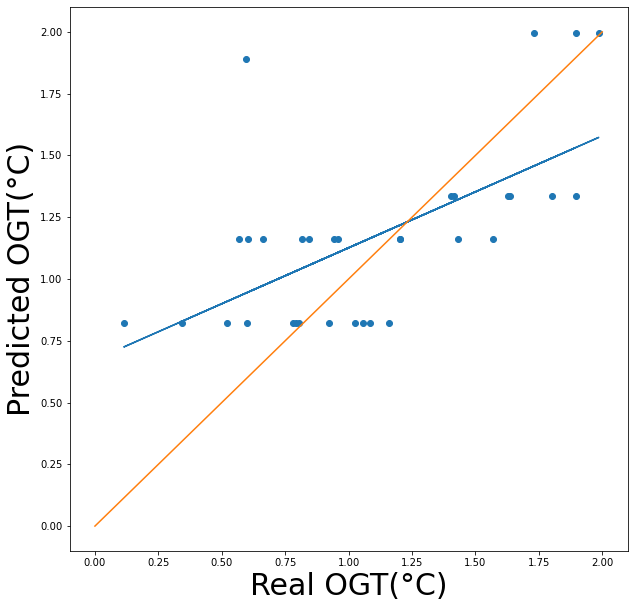

In [7]:
# plt.xlim(20,105)
# plt.ylim(20,105)
plt.xlabel('Real ' 'OGT(\u00B0C)', fontsize=30)
plt.ylabel('Predicted ' 'OGT(\u00B0C)',fontsize=30)

for k in range(it): 
    m = ast.literal_eval(lines[k])[5][0]
    b = ast.literal_eval(lines[k])[5][1]
    lst = [m*h+b for h in ast.literal_eval(lines[k])[8]]
    plt.plot(ast.literal_eval(lines[k])[8],lst)
    plt.scatter(ast.literal_eval(lines[k])[8], ast.literal_eval(lines[k])[7])
#     plt.scatter(ast.literal_eval(lines[k])[8], ycorrs[k])

rectax=[]

for l in range(0,3):
        rectax.append(l)
        
plt.plot(rectax,rectax)
    
    
# plt.savefig ('realvspred.jpg', bbox_inches='tight', dpi=300)
plt.show()

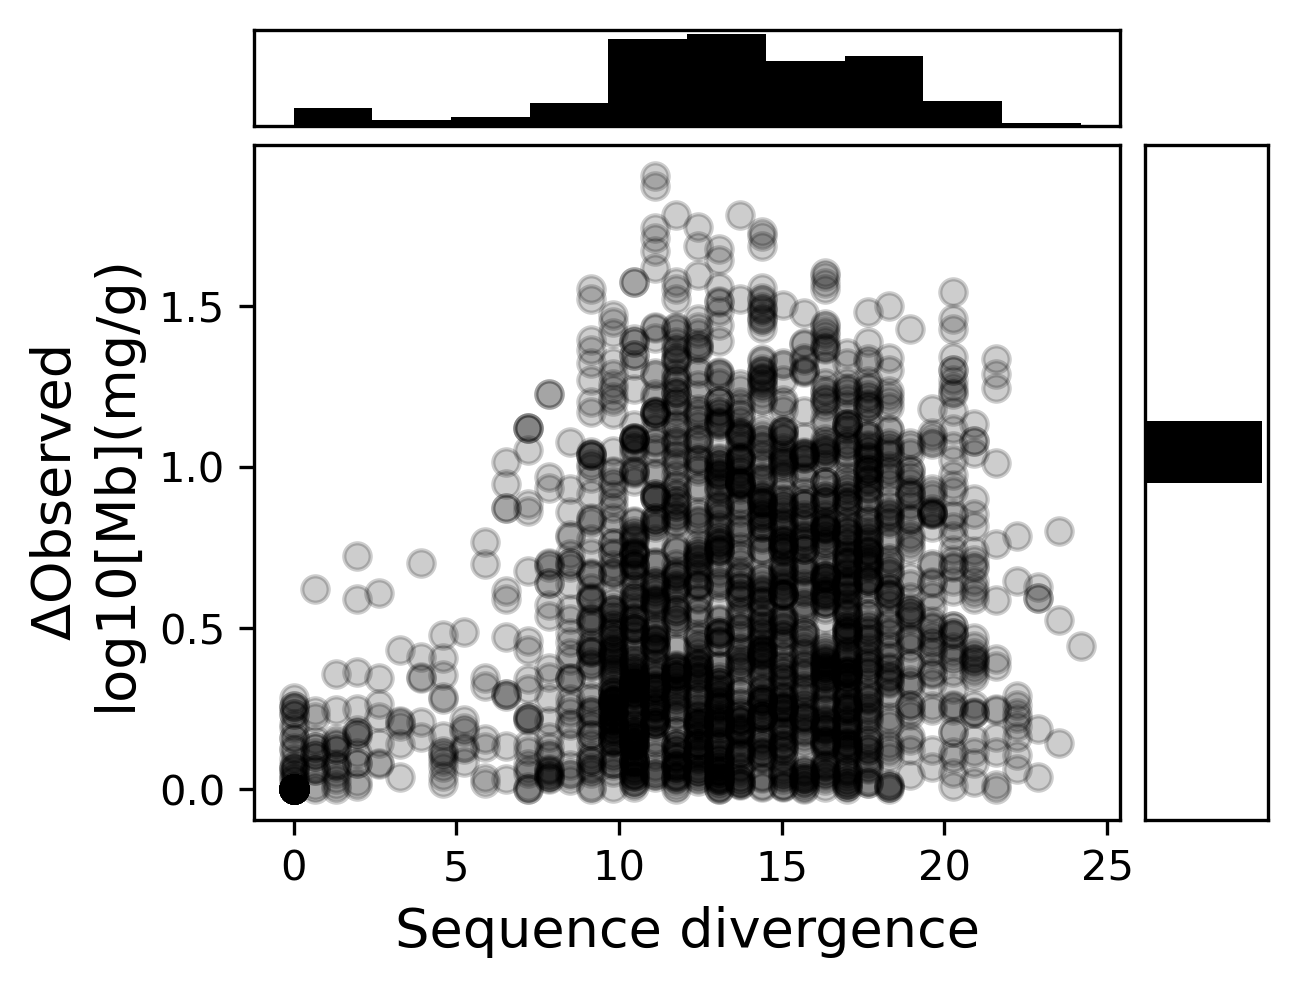

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# df = pd.read_csv('iris.csv')
########
figure_width = 5 # cm
figure_height = 4 # cm
left_right_magrin = 1 # cm
top_bottom_margin = 1 # cm
##########
# fig = plt.figure()
fig = plt.figure(figsize=(figure_width,figure_height), dpi=300)
# plt.xlabel('Amino Acid Residue', fontsize=13)
# plt.ylabel('Maximal Absorption Wavelength', fontsize=13)
# plt.tick_params(bottom='on', left='on')
plt.tight_layout()
# plt.legend(title='Position ', loc='upper right', title_fontsize=10)

gs = GridSpec(8, 8)

ax_scatter = fig.add_subplot(gs[1:7, 1:7])
ax_hist_x = fig.add_subplot(gs[0,1:7])
ax_hist_y = fig.add_subplot(gs[1:7, 7])


ax_scatter.scatter(df['sum'], df['dif'], s=40, facecolors= 'black', edgecolors='black', label='-o', alpha = 0.1)

ax_hist_x.hist(df['sum'], color = 'black', fill = True)
ax_hist_y.hist(df[1], orientation = 'horizontal', color = 'black', fill = True)

ax_hist_x.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax_hist_y.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

ax_scatter.set_xlabel('Sequence divergence', fontsize=13)
ax_scatter.set_ylabel(u"\u0394"'Observed \n' 'log10[Mb](mg/g)', fontsize=13)
ax_scatter.tick_params(axis='both')

ax_hist_x.ticklabel_format(axis = 'y', style='scientific', scilimits = (0,0))
ax_hist_y.ticklabel_format(axis = 'x', style='scientific', scilimits = (0,0))

# plt.savefig ('FiguraS1mbv2.jpg', bbox_inches='tight', dpi=300)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

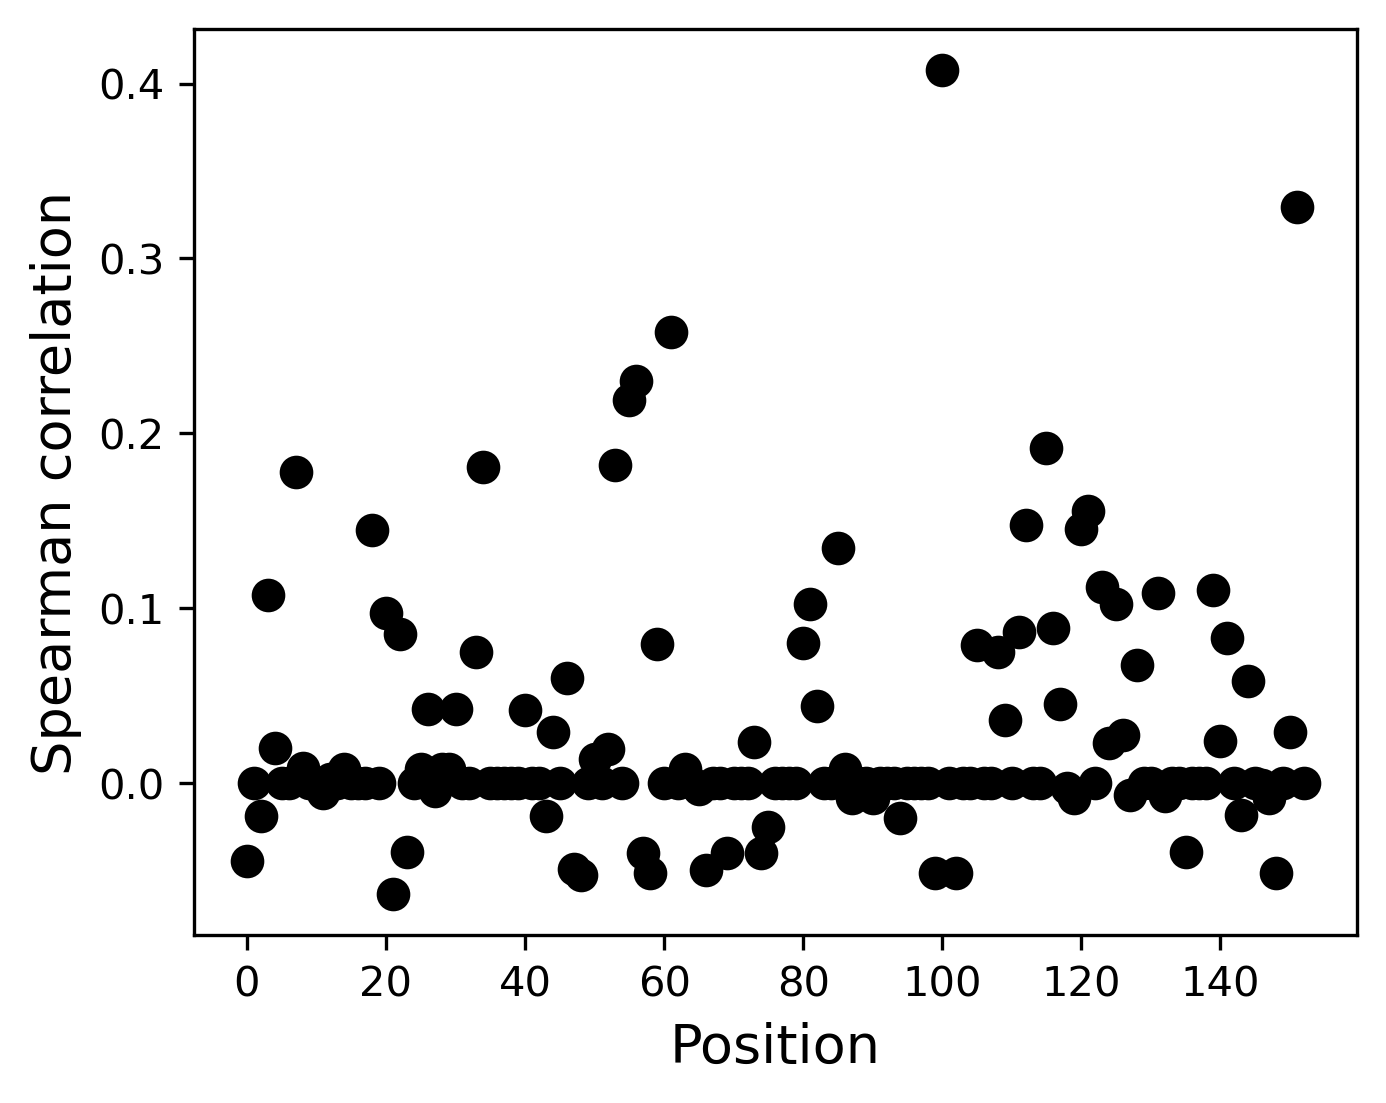

In [9]:
# ordered, indexes, indices, indices2, posicion, r2, rs
# df = pd.read_csv('iris.csv')
########
figure_width = 5 # cm
figure_height = 4 # cm
left_right_magrin = 1 # cm
top_bottom_margin = 1 # cm
##########
# fig = plt.figure()
fig = plt.figure(figsize=(figure_width,figure_height), dpi=300)
# plt.xlabel('Amino Acid Residue', fontsize=13)
# plt.ylabel('Maximal Absorption Wavelength', fontsize=13)
# plt.tick_params(bottom='on', left='on')
plt.tight_layout()
# plt.legend(title='Position ', loc='upper right', title_fontsize=10)

secundariox=[]
secundarioy=[]

for i in range(len(ordered)):

    x=ordered[i][0]
    y=ordered[i][1]
    
    secundariox.append(x)
    secundarioy.append(y)

plt.xlabel('Position', fontsize=13)
plt.ylabel('Spearman correlation',fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.rcParams.update({'font.size': 10})    
plt.scatter(secundariox,secundarioy, s=50, facecolors= 'black', edgecolors='black', label='-o') 
# plt.savefig ('secundario.jpg', bbox_inches='tight')
# plt.xlim(195,205)
plt.show


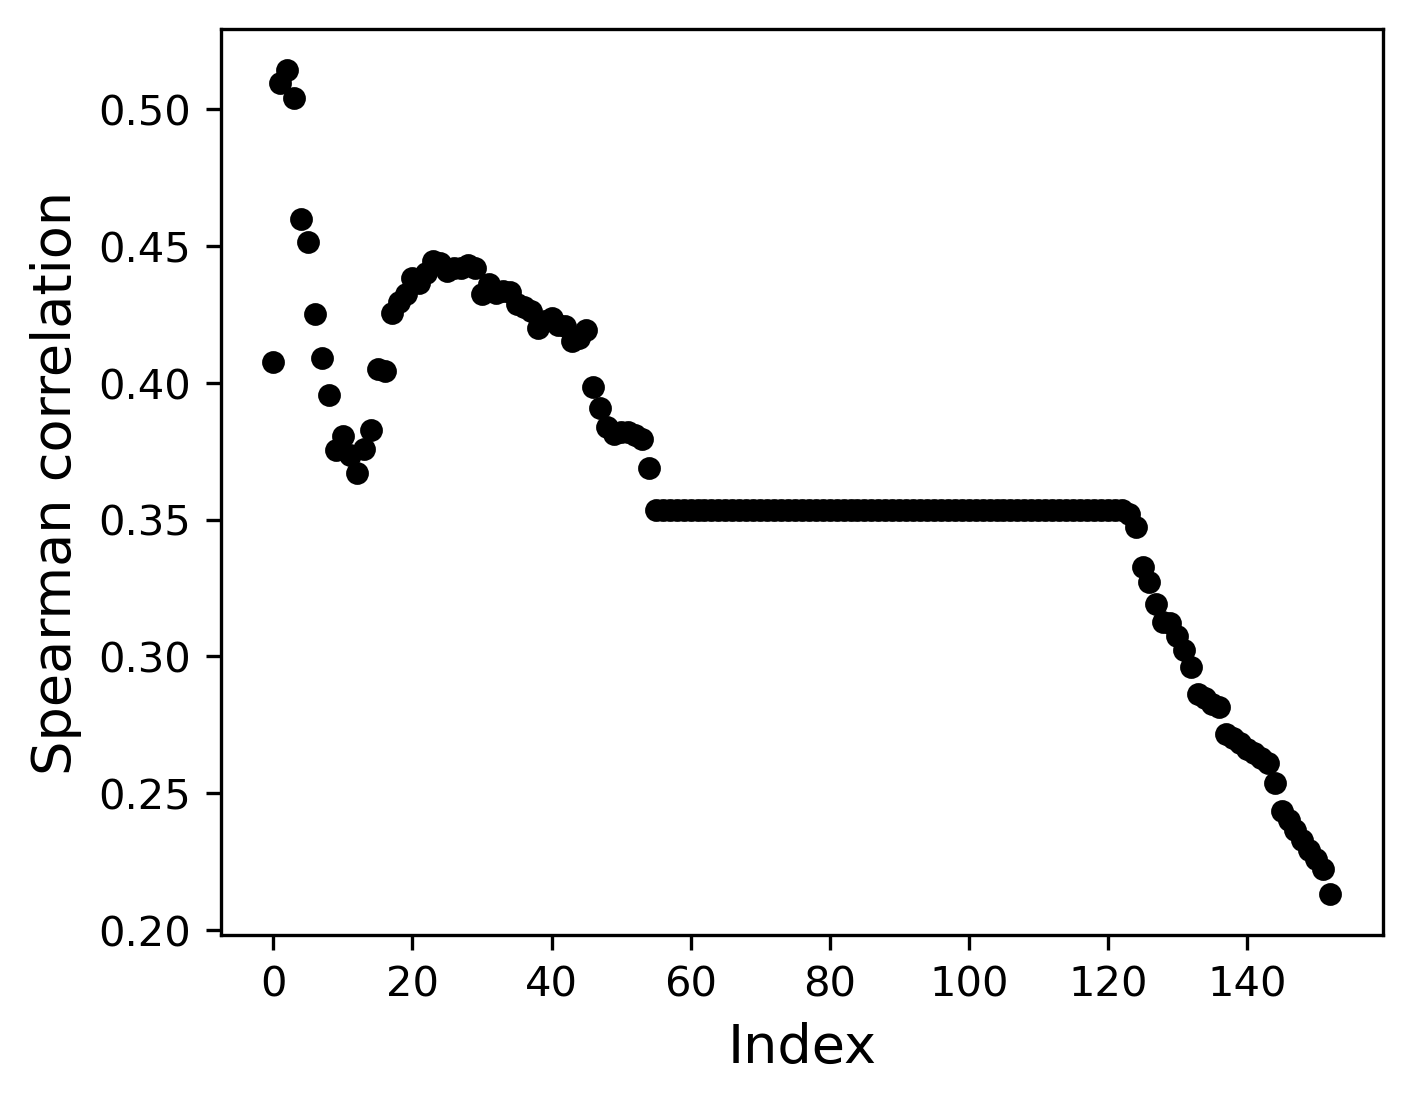

In [10]:
########
figure_width = 5 # cm
figure_height = 4 # cm
left_right_magrin = 1 # cm
top_bottom_margin = 1 # cm
##########
# fig = plt.figure()
fig = plt.figure(figsize=(figure_width,figure_height), dpi=300)
# plt.xlabel('Amino Acid Residue', fontsize=13)
# plt.ylabel('Maximal Absorption Wavelength', fontsize=13)
# plt.tick_params(bottom='on', left='on')
plt.tight_layout()
# plt.legend(title='Position ', loc='upper right', title_fontsize=10)

terciariox1=[]
terciarioy1=[]
terciarioy2=[]

for i in range(len(indexes)):
    
    x1=i
    y1=indexes[i][1]
    y2=r2[i]
    
    terciariox1.append(x1)
    terciarioy1.append(y1)
    terciarioy2.append(y2)
    
plt.xlabel('Index', fontsize=13)
plt.ylabel('Spearman correlation',fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.rcParams.update({'font.size': 10})    
# plt.scatter(terciariox1, terciarioy1, s=20, facecolors= 'black', edgecolors='black', marker='o')  
# plt.xlim(-1,100)
plt.scatter(terciariox1, terciarioy2, s=20, facecolors= 'black', edgecolors='black', marker='o')
# plt.savefig ('terciario.jpg', bbox_inches='tight', dpi=300)
plt.show()

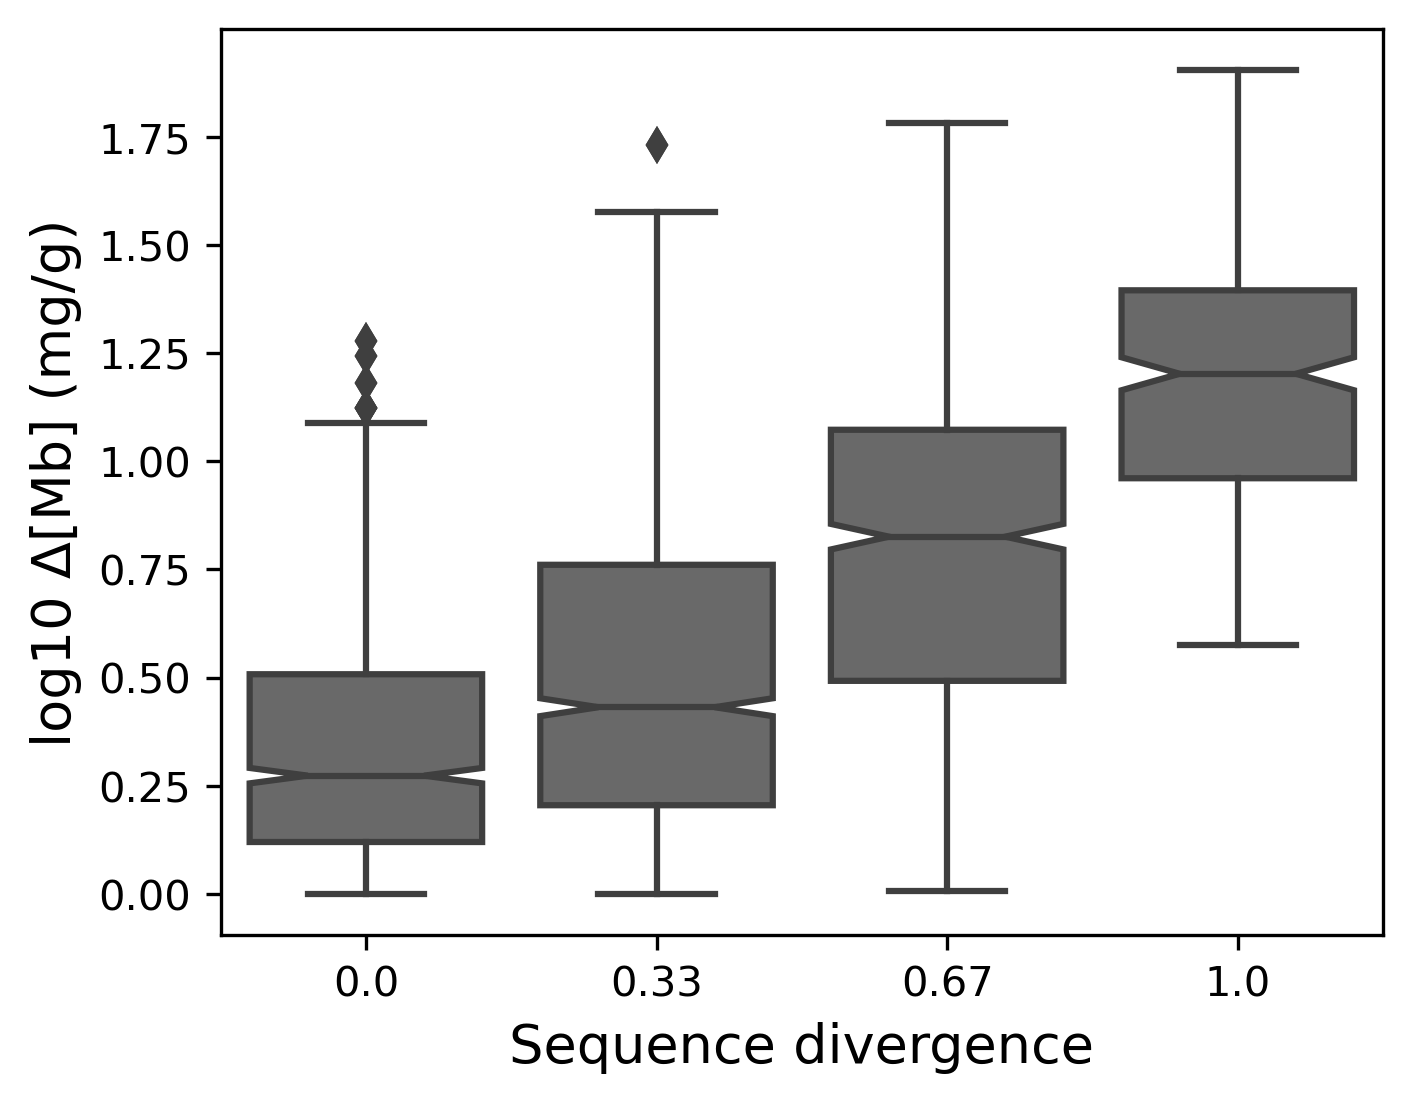

In [11]:
########
figure_width = 5 # cm
figure_height = 4 # cm
left_right_magrin = 1 # cm
top_bottom_margin = 1 # cm
##########
# fig = plt.figure()
fig = plt.figure(figsize=(figure_width,figure_height), dpi=300)
# plt.xlabel(fontsize=13)
# plt.ylabel(fontsize=13)
# plt.tick_params(bottom='on', left='on')
plt.tight_layout()
# plt.legend(title='Position ', loc='upper right', title_fontsize=10)
new = pd.DataFrame({'ploterciario': sumacal})
# new = dfcut2.filter(['ploterciario',1], axis=1)
new['ploterciario']=(new['ploterciario']/len(indices2)).round(2)
merged = pd.concat([new['ploterciario'], df['dif']], axis=1)
merged.columns = ['Sequence divergence', 'log10 'u"\u0394"'[Mb] (mg/g)']
b = sns.boxplot(x="Sequence divergence", y='log10 'u"\u0394"'[Mb] (mg/g)', data=merged, color = "dimgrey", notch=True)
# # sns.stripplot(x="ploterciario", y=1, data=new, color = "black")
b.set_xlabel("Sequence divergence",fontsize=13)
b.set_ylabel('log10 'u"\u0394"'[Mb] (mg/g)',fontsize=13)
# plt.savefig('cuaternariaNueva.png')
plt.show()